In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ast

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow.keras import backend as K
from transformers import TFRobertaForSequenceClassification

from transformers import RobertaTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# headline_cleaned

In [ ]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[feature_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# # Further split train set into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
# )

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [ ]:
# Define F1-score as a custom metric
def f1_score(y_true, y_pred):
    y_pred = tf.nn.sigmoid(y_pred)  # Convert logits to probabilities
    y_pred = K.round(y_pred)  # Convert probabilities to binary labels (0 or 1)

    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum((1 - y_true) * y_pred)  # False Positives
    fn = K.sum(y_true * (1 - y_pred))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

In [ ]:
# Enable GPU strategy for multi-GPU training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()
strategy

## Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
print(model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(56)

In [ ]:
MAX_LEN=64

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFRobertaModel

class RobertaLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(RobertaLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the BERT model
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")

    # Wrap the BERT model in a custom Keras layer
    roberta_layer = RobertaLayer(bert_model)
    output = roberta_layer({"input_ids": input_ids, "attention_mask": attention_masks})

    # Apply global average pooling and dense layer
    output = tf.keras.layers.GlobalAveragePooling1D()(output)
    output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(output)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Create the model
model = create_model(roberta_model, MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_8           │ (None, 64, 768)        │              0 │ attention_mask[0][0],  │
│ (RobertaLayer)            │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_8[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - binary_accuracy: 0.6561 - f1_score: 0.6130 - loss: 0.6170 - val_binary_accuracy: 0.7709 - val_f1_score: 0.6162 - val_loss: 0.5144
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7837 - f1_score: 0.6102 - loss: 0.4999 - val_binary_accuracy: 0.7978 - val_f1_score: 0.6162 - val_loss: 0.4675
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8051 - f1_score: 0.6102 - loss: 0.4622 - val_binary_accuracy: 0.8182 - val_f1_score: 0.6162 - val_loss: 0.4416
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8224 - f1_score: 0.6075 - loss: 0.4353 - val_binary_accuracy: 0.8238 - val_f1_score: 0.6162 - val_loss: 0.4245
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8222 - f1_score: 0.6064 - loss: 0.4216 - val_binary_accuracy: 0.8283 - val_f1_score: 0.6162 - val_loss: 0.4134
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])
y_pred_roberta = (result_roberta > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

           0       0.85      0.88      0.86      2997
           1       0.83      0.80      0.81      2345

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



## DistilBERT

In [ ]:
MAX_LEN=64

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel  # Import DistilBERT components

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Print the model architecture
print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def tokenize_distilbert(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_distilbert(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_distilbert(X_test, MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel  # Import DistilBERT instead of RoBERTa

class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert_model = distilbert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the DistilBERT model
        output = self.distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(distilbert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")

    # Wrap the DistilBERT model in a custom Keras layer
    distilbert_layer = DistilBertLayer(distilbert_model)
    output = distilbert_layer({"input_ids": input_ids, "attention_mask": attention_masks})

    # Apply global average pooling and dense layer
    output = tf.keras.layers.GlobalAveragePooling1D()(output)
    output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(output)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')  # Use DistilBERT

# Create the model
model = create_model(distilbert_model, MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distil_bert_layer         │ (None, 64, 768)        │              0 │ attention_mask[0][0],  │
│ (DistilBertLayer)         │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ distil_bert_layer[0][… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model.fit([train_input_ids,train_attention_masks], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - binary_accuracy: 0.6863 - f1_score: 0.6135 - loss: 0.5943 - val_binary_accuracy: 0.7978 - val_f1_score: 0.6162 - val_loss: 0.4678
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7933 - f1_score: 0.6036 - loss: 0.4562 - val_binary_accuracy: 0.8142 - val_f1_score: 0.6162 - val_loss: 0.4286
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8166 - f1_score: 0.6109 - loss: 0.4228 - val_binary_accuracy: 0.8262 - val_f1_score: 0.6162 - val_loss: 0.4075
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8206 - f1_score: 0.6089 - loss: 0.4061 - val_binary_accuracy: 0.8348 - val_f1_score: 0.6162 - val_loss: 0.3957
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8249 - f1_score: 0.6100 - loss: 0.3957 - val_binary_accuracy: 0.8381 - val_f1_score: 0.6162 - val_loss: 0.3876
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8294 

In [ ]:
result_distilbert = model.predict([test_input_ids,test_attention_masks])
y_pred_distilbert = (result_distilbert > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step


In [ ]:
print('\tClassification Report for DistilBERT:\n\n',classification_report(y_test,y_pred_distilbert))

	Classification Report for DistilBERT:

               precision    recall  f1-score   support

           0       0.86      0.87      0.87      2997
           1       0.84      0.82      0.83      2345

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



# NLTK lemmatized

In [ ]:
def convert_and_join(data, column_name):
    """
    Checks if a column can be converted to a list and then joins the elements with spaces.

    Args:
        data: The pandas DataFrame.
        column_name: The name of the column to check and convert.

    Returns:
        A pandas Series with the joined elements if conversion is successful, otherwise the original column.
    """
    try:
        # Attempt to convert the column to a list using ast.literal_eval
        data[column_name] = data[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

        # Join the elements of the list with spaces if it's a list
        data[column_name] = data[column_name].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

        return data[column_name]  # Return the modified column

    except (SyntaxError, ValueError):
        # If conversion fails, return the original column
        print(f"Warning: Column '{column_name}' could not be converted to a list.")
        return data[column_name]

In [ ]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
feature_col = 'lemmatized_text_nltk' #'lemmatized_text_nltk'

data[feature_col]  = convert_and_join(data, feature_col)
print(data['headline_length'].describe())

X = data[feature_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# # Further split train set into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
# )

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [ ]:
# Enable GPU strategy for multi-GPU training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()
strategy

## Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
print(model)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(52)

In [ ]:
MAX_LEN=64

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFRobertaModel

class RobertaLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(RobertaLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the BERT model
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")

    # Wrap the BERT model in a custom Keras layer
    roberta_layer = RobertaLayer(bert_model)
    output = roberta_layer({"input_ids": input_ids, "attention_mask": attention_masks})

    # Apply global average pooling and dense layer
    output = tf.keras.layers.GlobalAveragePooling1D()(output)
    output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(output)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Create the model
model = create_model(roberta_model, MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer             │ (None, 64, 768)        │              0 │ attention_mask[0][0],  │
│ (RobertaLayer)            │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ roberta_layer[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - binary_accuracy: 0.6282 - f1_score: 0.6081 - loss: 0.6402 - val_binary_accuracy: 0.7396 - val_f1_score: 0.6162 - val_loss: 0.5588
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7379 - f1_score: 0.6109 - loss: 0.5471 - val_binary_accuracy: 0.7553 - val_f1_score: 0.6162 - val_loss: 0.5224
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7532 - f1_score: 0.6070 - loss: 0.5199 - val_binary_accuracy: 0.7672 - val_f1_score: 0.6162 - val_loss: 0.5046
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7688 - f1_score: 0.6100 - loss: 0.4973 - val_binary_accuracy: 0.7707 - val_f1_score: 0.6162 - val_loss: 0.4936
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7724 - f1_score: 0.6087 - loss: 0.4859 - val_binary_accuracy: 0.7768 - val_f1_score: 0.6162 - val_loss: 0.4856
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])
y_pred_roberta = (result_roberta > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

           0       0.81      0.79      0.80      2997
           1       0.74      0.76      0.75      2345

    accuracy                           0.78      5342
   macro avg       0.77      0.78      0.77      5342
weighted avg       0.78      0.78      0.78      5342



## DistilBERT

In [ ]:
MAX_LEN=64

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel  # Import DistilBERT components

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Print the model architecture
print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def tokenize_distilbert(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_distilbert(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_distilbert(X_test, MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel  # Import DistilBERT instead of RoBERTa

class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert_model = distilbert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the DistilBERT model
        output = self.distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(distilbert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")

    # Wrap the DistilBERT model in a custom Keras layer
    distilbert_layer = DistilBertLayer(distilbert_model)
    output = distilbert_layer({"input_ids": input_ids, "attention_mask": attention_masks})

    # Apply global average pooling and dense layer
    output = tf.keras.layers.GlobalAveragePooling1D()(output)
    output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(output)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')  # Use DistilBERT

# Create the model
model = create_model(distilbert_model, MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distil_bert_layer         │ (None, 64, 768)        │              0 │ attention_mask[0][0],  │
│ (DistilBertLayer)         │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ distil_bert_layer[0][… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model.fit([train_input_ids,train_attention_masks], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - binary_accuracy: 0.6480 - f1_score: 0.6109 - loss: 0.6249 - val_binary_accuracy: 0.7337 - val_f1_score: 0.6162 - val_loss: 0.5428
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7360 - f1_score: 0.6101 - loss: 0.5376 - val_binary_accuracy: 0.7536 - val_f1_score: 0.6162 - val_loss: 0.5156
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7498 - f1_score: 0.6084 - loss: 0.5205 - val_binary_accuracy: 0.7588 - val_f1_score: 0.6162 - val_loss: 0.5034
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7593 - f1_score: 0.6158 - loss: 0.5009 - val_binary_accuracy: 0.7644 - val_f1_score: 0.6162 - val_loss: 0.4993
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7670 - f1_score: 0.6143 - loss: 0.4946 - val_binary_accuracy: 0.7695 - val_f1_score: 0.6162 - val_loss: 0.4886
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7619 

In [ ]:
result_distilbert = model.predict([test_input_ids,test_attention_masks])
y_pred_distilbert = (result_distilbert > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


In [ ]:
print('\tClassification Report for DistilBERT:\n\n',classification_report(y_test,y_pred_distilbert))

	Classification Report for DistilBERT:

               precision    recall  f1-score   support

           0       0.78      0.84      0.81      2997
           1       0.77      0.70      0.73      2345

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342



# Combine text and engineered features

In [ ]:
data.columns

Index(['headline', 'headline_cleaned', 'tokenized_text_nltk',
       'pos_tagged_text_nltk', 'lemmatized_text_nltk', 'headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_w

In [ ]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_spacy.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
numerical_col = ['headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_words',
       'readability', 'sentiment']
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[[feature_col] + numerical_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# # Further split train set into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
# )

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [ ]:
# Enable GPU strategy for multi-GPU training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()
strategy

## Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
print(model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
token_lens = []

for txt in X_train[feature_col]:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(56)

In [ ]:
MAX_LEN=64

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train[feature_col], MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test[feature_col], MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFRobertaModel

import tensorflow as tf
from transformers import TFRobertaModel, TFAutoModel

class RobertaLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(RobertaLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        output = self.bert_model(input_ids=inputs[0], attention_mask=inputs[1])
        return output[0]  # Return the last hidden state

def create_model(roberta_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    roberta_layer = RobertaLayer(roberta_model)
    roberta_output = roberta_layer([input_ids, attention_masks])

    roberta_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
    combined = tf.keras.layers.Concatenate()([roberta_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Create the model
model = create_model(roberta_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_5           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_5[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 807)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │         51,712 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks, X_train.drop(feature_col, axis=1)], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - binary_accuracy: 0.6373 - f1_score: 0.6058 - loss: 0.8894 - val_binary_accuracy: 0.8032 - val_f1_score: 0.6162 - val_loss: 0.4339
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8054 - f1_score: 0.6095 - loss: 0.4330 - val_binary_accuracy: 0.8446 - val_f1_score: 0.6162 - val_loss: 0.3781
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8302 - f1_score: 0.6123 - loss: 0.3831 - val_binary_accuracy: 0.8465 - val_f1_score: 0.6162 - val_loss: 0.3509
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8490 - f1_score: 0.6041 - loss: 0.3523 - val_binary_accuracy: 0.8556 - val_f1_score: 0.6162 - val_loss: 0.3346
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8471 - f1_score: 0.5993 - loss: 0.3440 - val_binary_accuracy: 0.8631 - val_f1_score: 0.6162 - val_loss: 0.3246
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred_roberta = (result_roberta > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

           0       0.87      0.88      0.88      2997
           1       0.85      0.83      0.84      2345

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



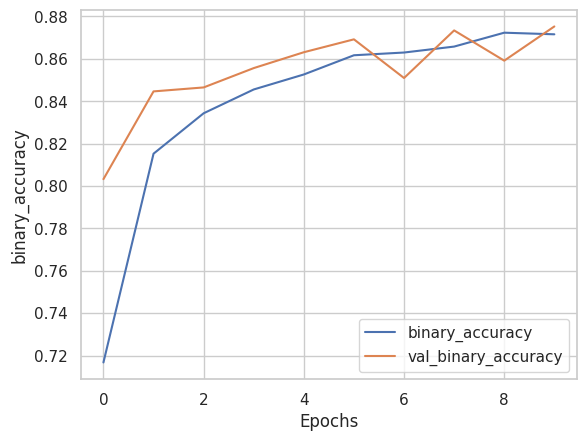

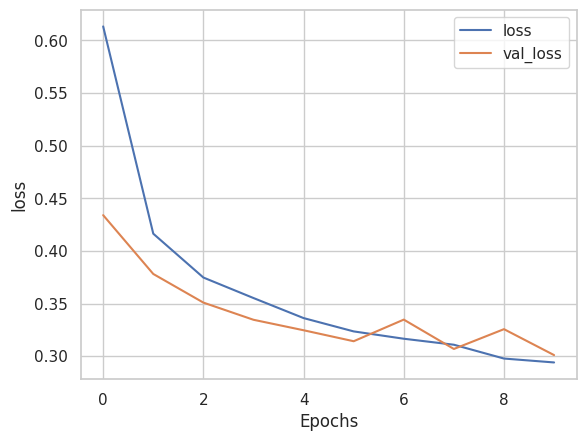

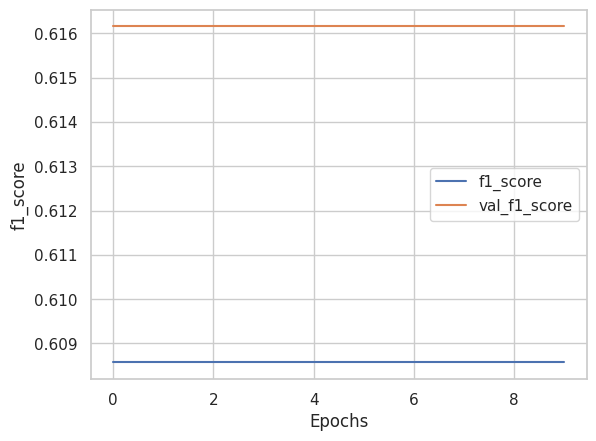

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_2, 'binary_accuracy')
plot_graphs(history_2, 'loss')
plot_graphs(history_2, 'f1_score')

## DistilBERT

In [ ]:
MAX_LEN=64

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel  # Import DistilBERT components

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Print the model architecture
print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def tokenize_distilbert(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_distilbert(X_train[feature_col], MAX_LEN)
test_input_ids, test_attention_masks = tokenize_distilbert(X_test[feature_col], MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel  # Import DistilBERT instead of RoBERTa

class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert_model = distilbert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the DistilBERT model
        output = self.distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(distilbert_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    roberta_layer = RobertaLayer(distilbert_model)
    roberta_output = roberta_layer([input_ids, attention_masks])

    roberta_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
    combined = tf.keras.layers.Concatenate()([roberta_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')  # Use DistilBERT

# Create the model
model = create_model(distilbert_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_7           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_7[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 807)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │         51,712 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │             65 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model.fit([train_input_ids,train_attention_masks, X_train.drop(feature_col, axis=1)], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - binary_accuracy: 0.6924 - f1_score: 0.6063 - loss: 0.6394 - val_binary_accuracy: 0.8376 - val_f1_score: 0.6162 - val_loss: 0.3893
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8265 - f1_score: 0.6083 - loss: 0.3888 - val_binary_accuracy: 0.8460 - val_f1_score: 0.6162 - val_loss: 0.3571
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8451 - f1_score: 0.6071 - loss: 0.3627 - val_binary_accuracy: 0.8231 - val_f1_score: 0.6162 - val_loss: 0.4049
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8453 - f1_score: 0.6141 - loss: 0.3495 - val_binary_accuracy: 0.8624 - val_f1_score: 0.6162 - val_loss: 0.3223
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8601 - f1_score: 0.6100 - loss: 0.3230 - val_binary_accuracy: 0.8678 - val_f1_score: 0.6162 - val_loss: 0.3136
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8666 

In [ ]:
result_distilbert = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred_distilbert = (result_distilbert > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


In [ ]:
print('\tClassification Report for DistilBERT:\n\n',classification_report(y_test,y_pred_distilbert))

	Classification Report for DistilBERT:

               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2997
           1       0.86      0.86      0.86      2345

    accuracy                           0.88      5342
   macro avg       0.88      0.88      0.88      5342
weighted avg       0.88      0.88      0.88      5342



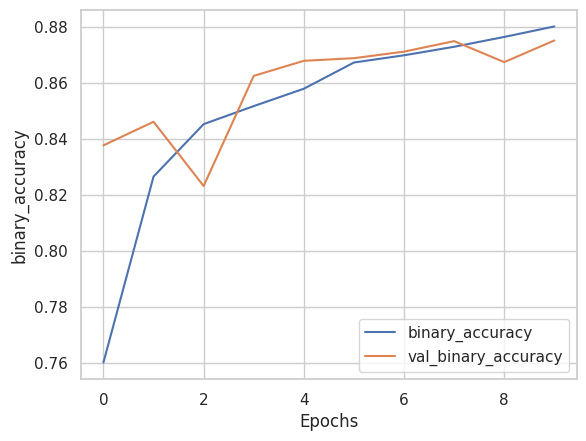

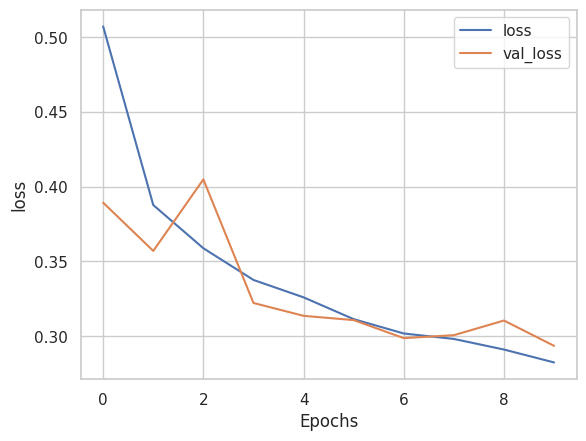

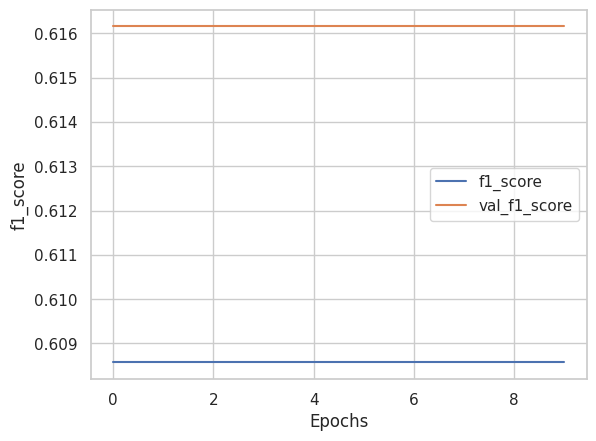

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_1, 'binary_accuracy')
plot_graphs(history_1, 'loss')
plot_graphs(history_1, 'f1_score')

# Hyperparameter Tuning

In [ ]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Roberta/features_spacy.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
numerical_col = ['headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_words',
       'readability', 'sentiment']
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[[feature_col] + numerical_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# # Further split train set into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
# )

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [ ]:
# Enable GPU strategy for multi-GPU training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()
strategy

## Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
print(model)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
token_lens = []

for txt in X_train[feature_col]:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(56)

In [ ]:
MAX_LEN=64

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train[feature_col], MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test[feature_col], MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFRobertaModel

import tensorflow as tf
from transformers import TFRobertaModel, TFAutoModel

class RobertaLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(RobertaLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        output = self.bert_model(input_ids=inputs[0], attention_mask=inputs[1])
        return output[0]  # Return the last hidden state

def create_model(roberta_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2,
                 opt=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
                 activation_func='relu'):


   #opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    roberta_layer = RobertaLayer(roberta_model)
    roberta_output = roberta_layer([input_ids, attention_masks])

    roberta_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
    combined = tf.keras.layers.Concatenate()([roberta_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation=activation_func)(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Create the model
model = create_model(roberta_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer             │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ roberta_layer[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 807)            │              0 │ global_average_poolin… │
│                           │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         51,712 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# pip install keras-tuner
import keras_tuner as kt

def model_builder(hp):
    # Define hyperparameter search space
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'swish'])

    # Load the RoBERTa model inside model_builder
    roberta_model = TFRobertaModel.from_pretrained('roberta-base')

    # Build the model with hyperparameters
    model = create_model(
        roberta_model,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), # Pass optimizer instance
        activation_func=hp_activation
    )

    print(model.summary())

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/content/drive/MyDrive/CS4248/Roberta',
                     project_name='roberta_tuned')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Perform hyperparameter search
tuner.search([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
             y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[stop_early])



Reloading Tuner from /content/drive/MyDrive/CS4248/Roberta/roberta_tuned/tuner0.json


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_units')}, the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, the optimal dropout rate is 0.30000000000000004,
and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
                    y_train,
                    epochs=6,
                    validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy, f1_score = model.evaluate([test_input_ids, test_attention_masks, X_test.drop(feature_col, axis=1)], y_test, verbose=2)
print('Test accuracy:', accuracy)
print('Test f1_score:', f1_score)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_2           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_2[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 807)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        103,424 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 103,553 (404.50 KB)

 Trainable params: 103,553 (404.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - binary_accuracy: 0.6613 - f1_score: 0.6084 - loss: 0.6068 - val_binary_accuracy: 0.7908 - val_f1_score: 0.6162 - val_loss: 0.4508
Epoch 2/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - binary_accuracy: 0.8055 - f1_score: 0.6072 - loss: 0.4300 - val_binary_accuracy: 0.8086 - val_f1_score: 0.6162 - val_loss: 0.4093
Epoch 3/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - binary_accuracy: 0.8311 - f1_score: 0.6064 - loss: 0.3858 - val_binary_accuracy: 0.8397 - val_f1_score: 0.6162 - val_loss: 0.3683
Epoch 4/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.8423 - f1_score: 0.6136 - loss: 0.3632 - val_binary_accuracy: 0.8446 - val_f1_score: 0.6162 - val_loss: 0.3571
Epoch 5/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - binary_accuracy: 0.8475 - f1_score: 0.6077 - loss: 0.3508 - val_binary_accuracy: 0.8458 - val_f1_score: 0.6162 - val_loss: 0.3445
Epoch 6/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - binary_accuracy: 0.8

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred_roberta = (result_roberta > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

           0       0.87      0.88      0.87      2997
           1       0.84      0.83      0.84      2345

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



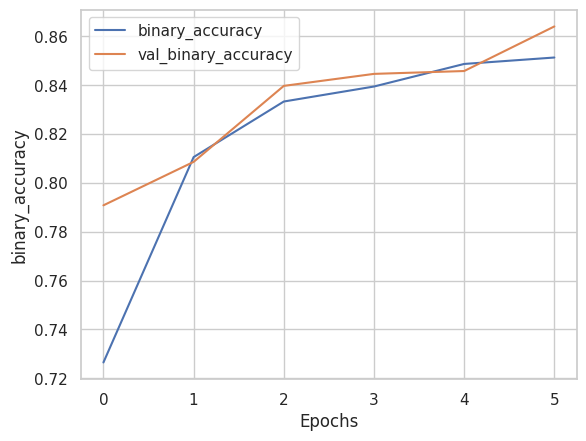

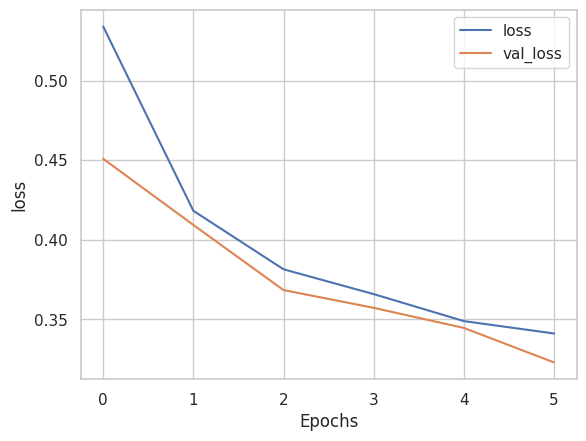

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'binary_accuracy')
plot_graphs(history, 'loss')

## DistilBERT

In [ ]:
MAX_LEN=64

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel  # Import DistilBERT components

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Print the model architecture
print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def tokenize_distilbert(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_distilbert(X_train[feature_col], MAX_LEN)
test_input_ids, test_attention_masks = tokenize_distilbert(X_test[feature_col], MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel  # Import DistilBERT instead of RoBERTa

class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert_model = distilbert_model

    def call(self, inputs):
        # Ensure inputs are TensorFlow tensors
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Pass inputs to the DistilBERT model
        output = self.distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output[0]  # Return the last hidden state

def create_model(distilbert_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2,
                 opt=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
                 activation_func='relu'):


   #opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    roberta_layer = RobertaLayer(distilbert_model)
    roberta_output = roberta_layer([input_ids, attention_masks])

    roberta_output = tf.keras.layers.GlobalAveragePooling1D()(roberta_output)
    combined = tf.keras.layers.Concatenate()([roberta_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation=activation_func)(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')  # Use DistilBERT

# Create the model
model = create_model(distilbert_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_4           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_4[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 807)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │         51,712 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# pip install keras-tuner
import keras_tuner as kt

def model_builder(hp):
    # Define hyperparameter search space
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'swish'])

    # Load the RoBERTa model inside model_builder
    distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Build the model with hyperparameters
    model = create_model(
        distilbert_model,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), # Pass optimizer instance
        activation_func=hp_activation
    )

    print(model.summary())

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/content/drive/MyDrive/CS4248/Roberta',
                     project_name='distilbert_tuned')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Perform hyperparameter search
tuner.search([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
             y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[stop_early])



Trial 30 Complete [00h 01m 39s]
val_binary_accuracy: 0.8135236501693726

Best val_binary_accuracy So Far: 0.8865231871604919
Total elapsed time: 00h 21m 27s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_units')}, the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, the optimal dropout rate is 0.30000000000000004,
and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
                    y_train,
                    epochs=15,
                    validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy, f1_score = model.evaluate([test_input_ids, test_attention_masks, X_test.drop(feature_col, axis=1)], y_test, verbose=2)
print('Test accuracy:', accuracy)
print('Test f1_score:', f1_score)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ roberta_layer_2           │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│ (RobertaLayer)            │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ roberta_layer_2[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 807)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        103,424 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 103,553 (404.50 KB)

 Trainable params: 103,553 (404.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - binary_accuracy: 0.6970 - f1_score: 0.6044 - loss: 0.7002 - val_binary_accuracy: 0.8425 - val_f1_score: 0.6162 - val_loss: 0.3754
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8265 - f1_score: 0.6056 - loss: 0.3958 - val_binary_accuracy: 0.8514 - val_f1_score: 0.6162 - val_loss: 0.3489
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8397 - f1_score: 0.6098 - loss: 0.3588 - val_binary_accuracy: 0.8479 - val_f1_score: 0.6162 - val_loss: 0.3467
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8537 - f1_score: 0.6052 - loss: 0.3295 - val_binary_accuracy: 0.8463 - val_f1_score: 0.6162 - val_loss: 0.3518
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8573 - f1_score: 0.6049 - loss: 0.3256 - val_binary_accuracy: 0.8671 - val_f1_score: 0.6162 - val_loss: 0.3099
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.

In [ ]:
result_distilbert = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred_distilbert = (result_distilbert > 0.5).astype(int)
# y_pred_roberta =  np.zeros_like(result_roberta)
# y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


In [ ]:
print('\tClassification Report for DistilBERT:\n\n',classification_report(y_test,y_pred_distilbert))

	Classification Report for DistilBERT:

               precision    recall  f1-score   support

           0       0.88      0.92      0.90      2997
           1       0.89      0.84      0.86      2345

    accuracy                           0.88      5342
   macro avg       0.88      0.88      0.88      5342
weighted avg       0.88      0.88      0.88      5342



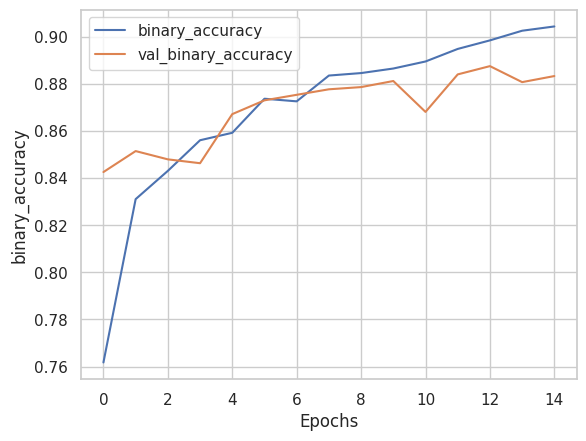

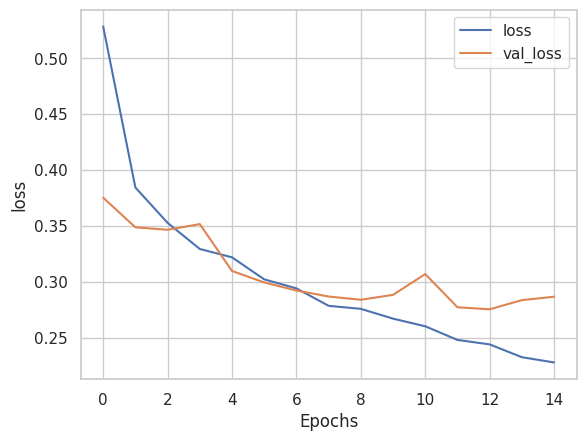

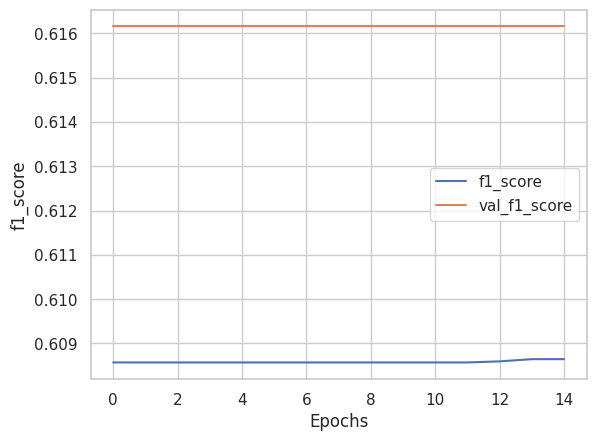

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'binary_accuracy')
plot_graphs(history, 'loss')
plot_graphs(history, 'f1_score')